# Using RETVec to train an emotion classifier

RETVec is a state-of-the-art text vectorizer which works directly on text inputs to create resilient classification models. Models trained with RETVec achieve better classification performance with fewer parameters and exhibit stronger resilience against adversarial attacks and typos, as reported in our [paper](https://arxiv.org/abs/2302.09207).

RETVec's speed and fewer parameters (~200k instead of millions) makes it a great choice to train and deploy small and efficient on-device models. It is natively supported in TensorFlow Lite via custom ops implemented in TensorFlow Text, and we provide a Javascript implementation of RETVec which allows you to deploy web models via TensorFlow.js.

This notebook demonstrates how to quickly train and use a text emotion classifier in TensorFlow.

Let's get started!

In [1]:
# installing needed dependencies
try:
    import retvec
except ImportError:
    !pip install retvec  # is retvec installed?

try:
    import datasets
except ImportError:
    !pip install datasets  # used to get the dataset

try:
    import matplotlib
except ImportError:
    !pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 417.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 368.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-similarity 0.18.0.dev5 requires bokeh, which is not installed.
tensorflow-similarity 0.18.0.dev5 requires tabulate, which is not installed.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # silence TF INFO messages
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from datasets import load_dataset
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:4', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:5', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:6', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:7', device_type='GPU')]

In this notebook we are using the `RETVecTokenizer()` layer which perform the binarization and embedding in a single step. This is the best approach for GPU training. For TPU training,
it is more efficient to split the two steps -- see our TPU training notbook for this.

In [4]:
# import the RETVec tokenizer layer
from retvec.tf import RETVecTokenizer

## Create dataset

We are going to use the [Go Emotion dataset](https://huggingface.co/datasets/go_emotions) to create a mulit-class emotion classifier.
https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html

In [5]:
# downloading dataset
dataset = load_dataset('go_emotions')

In [6]:
# get class name mapping and number of class
CLASSES = dataset['train'].features['labels'].feature.names
NUM_CLASSES = len(CLASSES)
print(f"num classes {NUM_CLASSES}")
print(CLASSES)

num classes 28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [7]:
# preparing data
x_train = tf.constant(dataset['train']['text'], dtype=tf.string)

# the one-hot requires a little more due to the multi-class nature of the dataset.
y_train = np.zeros((len(x_train),NUM_CLASSES))
for idx, ex in enumerate(dataset['train']['labels']):
    for val in ex:
        y_train[idx][val] = 1

# test data
x_test = tf.constant(dataset['test']['text'], dtype=tf.string)
y_test = np.zeros((len(x_test),NUM_CLASSES))
for idx, ex in enumerate(dataset['test']['labels']):
    for val in ex:
        y_test[idx][val] = 1


## Model

A key benefit of using RETVec is that inputs to RETVec and the text model are raw strings with no pre-processing neccessary, which greatly simplifies the training and inference process, especially for on-device models.

Notes:
- Using strings directly as input requires to use a shape of `(1,)` and specify the type `tf.string`
- We are using `RETVecTokenizer()` in its default configuration which is to truncate at `128` words and use a small pre-trained word embedding model to embed the words. You can experiment with shorter or longer length by changing the `sequence_length` parameter. The word embedding model offers significant improvements in adversarial and typo robustness. To use the RETVec character tokenizer only, set `model=None`.

In [8]:
# using strings directly requires to put a shape of (1,) and dtype tf.string
inputs = layers.Input(shape=(1, ), name="token", dtype=tf.string)

# add RETVec tokenizer layer with default settings -- this is all you have to do to build a model with RETVec!
x = RETVecTokenizer(model='retvec-v1')(inputs)

# standard two layer LSTM
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token (InputLayer)          [(None, 1)]               0         
                                                                 
 ret_vec_tokenizer (RETVecTo  (None, 128, 256)         230144    
 kenizer)                                                        
                                                                 
 bidirectional (Bidirectiona  (None, 128, 128)         164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 28)                3612      
                                                             

In [10]:
# compile and train the model like usual
batch_size = 256
epochs = 25
model.compile('adam', 'binary_crossentropy', ['acc'])
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_test, y_test))

Epoch 1/25
170/170 [==============================] - 19s 79ms/step - loss: 0.0823 - acc: 0.5885 - val_loss: 0.0996 - val_acc: 0.5272
Epoch 2/25
104/170 [=================>............] - ETA: 4s - loss: 0.0806 - acc: 0.5974

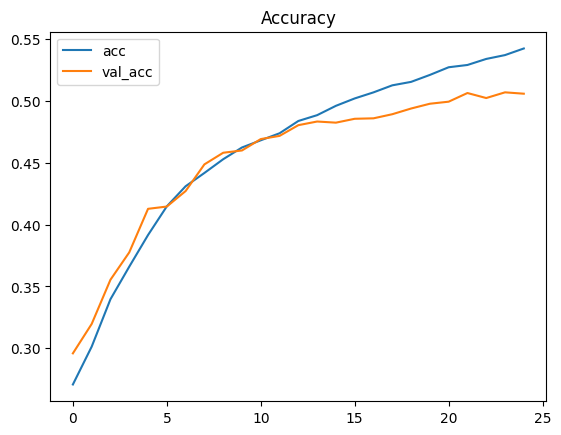

In [ ]:
# visualize the training curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title(f'Accuracy')
plt.show()

## Save & Reload Keras Model

Let's save our model, then test it on some examples.

In [ ]:
# saving the model
save_path = 'demo_models/emotion_model'
model.save(save_path)

model = tf.keras.models.load_model(save_path, compile=False)

2023-10-09 17:54:10.843536: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-09 17:54:10.905327: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OSError: SavedModel file does not exist at: demo_models/emotion_model/{saved_model.pbtxt|saved_model.pb}

In [ ]:
def predict_emotions(txt, threshold=0.5):
    # recall it is multi-class so we need to get all prediction above a threshold (0.5)
    preds = model(tf.constant([txt]))[0]
    out = 0
    for i in range(NUM_CLASSES):
        if preds[i] > threshold:
            emotion_name = CLASSES[i]
            emotion_prob = round(float(preds[i]) * 100, 1)
            print(f"{emotion_name} ({emotion_prob})%")
            out += 1
    if not out:
        print("neutral")

In [ ]:
txt = "I enjoy having a good icecream."
predict_emotions(txt)

joy (84.7)%


In [ ]:
# the model works even with typos, substitutions, and emojis!
txt = "I enjoy hving a g00d ic3cream!!! 🍦"
predict_emotions(txt)

joy (89.5)%
